In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 12

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, t1, trise, tfall):
    return (A + B*(t1-t0))*np.exp(-(t-t1)/tfall)/(1+np.exp(-(t-t0)/trise))

In [3]:
#These are the values we are going to use for a test
np.random.seed(212)
trise_A = .3
tfall_A = 2
Amplitude_A = 10.5
Beta_A = -.4
t0_A = 6.7
t1_A = float(15)
end_A = 50
size = 25 #data set size double for total observations
sigma_A = 1 #Telescope error

In [4]:
time_axis_rise = np.random.uniform(low=0, high=t1_A, size=size)
time_axis_fall = np.random.uniform(low=t1_A, high=end_A, size=size)
Y_actual_rise = SuperNova_CurveRise(time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A)
Y_actual_fall = SuperNova_CurveFall(time_axis_fall, Amplitude_A, Beta_A, t0_A, t1_A, trise_A, tfall_A)
time_axis = np.append(time_axis_rise, time_axis_fall)
Y_actual = np.append(Y_actual_rise, Y_actual_fall)
Y_observed = Y_actual + np.random.normal(0,sigma_A, len(Y_actual))

Text(0.5, 1.0, 'Actual Light Curve')

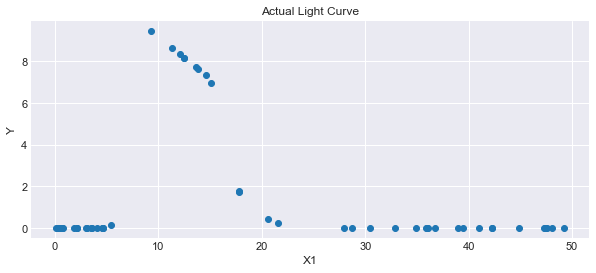

In [5]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_actual)
axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Actual Light Curve")

Text(0.5, 1.0, 'Observed Light Curve')

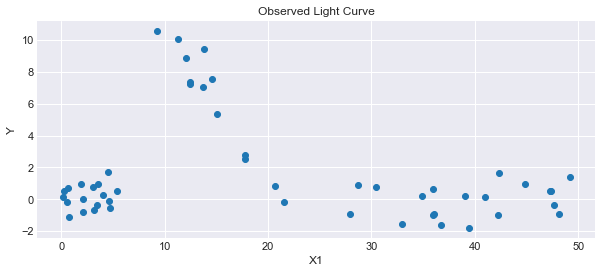

In [6]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_observed)
axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

In [7]:
basic_model = pm.Model()

In [8]:
with basic_model:

    # Priors for unknown model parameters
    AboveZeroBound = pm.Bound(pm.Normal, lower = 0.0)
    BelowZeroBound = pm.Bound(pm.Normal, upper = 0.0)
    trise = AboveZeroBound('trise', mu=0, sigma=10)
    tfall = AboveZeroBound('tfall', mu=0, sigma=10)
    Amplitude = AboveZeroBound('Amplitude', mu=np.max(Y_observed)-np.min(Y_observed), sigma=1)
    Beta = BelowZeroBound('Beta', mu=0, sigma=10)
    t0 = AboveZeroBound('t0', mu=0, sigma=10)
    t1 = pm.DiscreteUniform('t1', lower = np.min(time_axis), upper = np.max(time_axis))
    sigma = pm.HalfNormal('sigma', sigma=sigma_A)
    
    # Expected value of outcome
    mu_rise = SuperNova_CurveRise(time_axis, Amplitude, Beta, t0, trise)
    mu_fall = SuperNova_CurveFall(time_axis, Amplitude, Beta, t0, t1, trise, tfall)
    
    mu_switch = pm.math.switch(t1 >= time_axis, mu_rise, mu_fall)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed)

In [9]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -85.186, ||grad|| = 0.24919: 100%|████████████████████████████████████████████| 85/85 [00:00<00:00, 2520.13it/s]


{'trise_lowerbound__': array(-3.67435019),
 'tfall_lowerbound__': array(0.32422764),
 'Amplitude_lowerbound__': array(2.52383621),
 'Beta_upperbound__': array(-0.07032107),
 't0_lowerbound__': array(2.07826969),
 't1': array(24, dtype=int64),
 'sigma_log__': array(-0.09725824),
 'trise': array(0.02536588),
 'tfall': array(1.38296209),
 'Amplitude': array(12.47636693),
 'Beta': array(-0.9320945),
 't0': array(7.99063066),
 'sigma': array(0.90732167)}

In [10]:
with basic_model:
    # 1000 posterior samples
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, t0, Beta, Amplitude, tfall, trise]
>Metropolis: [t1]
Sampling 4 chains, 434 divergences: 100%|████████████████████████████████████| 42000/42000 [00:53<00:00, 790.00draws/s]
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.885017208089054, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5481BD888>,
      dtype=object)

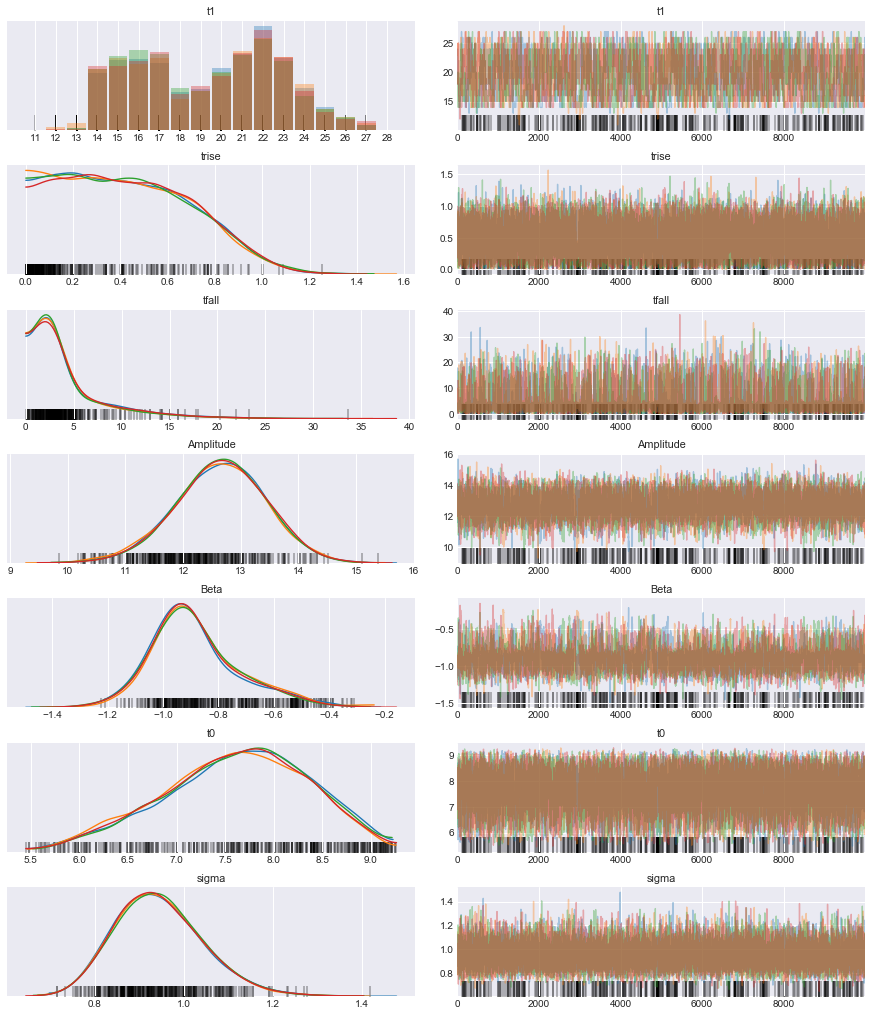

In [11]:
%matplotlib inline
pm.traceplot(trace)

In [12]:
summary_table = pm.summary(trace)
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
t1,19.331,3.454,14.000,24.000,0.105,0.075,1075.0,1075.0,1095.0,1509.0,1.0
trise,0.432,0.271,0.000,0.876,0.003,0.002,8582.0,8582.0,7426.0,6998.0,1.0
tfall,4.180,4.088,0.000,12.178,0.053,0.038,5852.0,5852.0,6591.0,7986.0,1.0
Amplitude,12.650,0.781,11.120,14.072,0.012,0.009,4143.0,4143.0,4324.0,4111.0,1.0
Beta,-0.884,0.163,-1.158,-0.533,0.004,0.003,1780.0,1780.0,2155.0,2238.0,1.0
t0,7.614,0.744,6.225,8.979,0.009,0.007,6221.0,6221.0,6297.0,8682.0,1.0
sigma,0.946,0.099,0.772,1.135,0.001,0.001,18811.0,18772.0,18453.0,16687.0,1.0


In [13]:
trise_R = summary_table["mean"]["trise"]
tfall_R = summary_table["mean"]["tfall"]
Amplitude_R = summary_table["mean"]["Amplitude"]
Beta_R = summary_table["mean"]["Beta"]
t0_R = summary_table["mean"]["t0"]
t1_R = summary_table["mean"]["t1"]

In [14]:
print(trise_R)
print(tfall_R)
print(Amplitude_R)
print(Beta_R)
print(t0_R)
print(t1_R)

0.432
4.18
12.65
-0.884
7.614
19.331


Text(0, 0.5, 'y_observed')

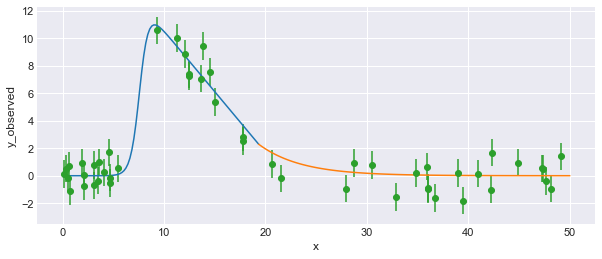

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t1_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t1_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, t1_R, trise_R, tfall_R))

ax.errorbar(time_axis, Y_observed, sigma_A, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y_observed')

Text(0, 0.5, 'y_actual')

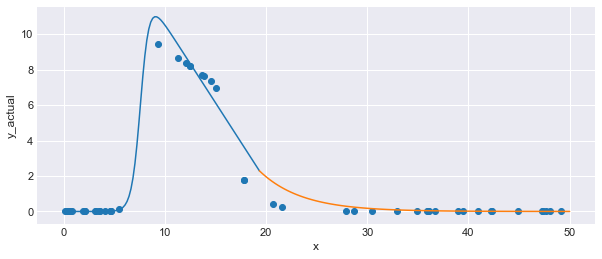

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t1_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t1_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, t1_R, trise_R, tfall_R))

ax.scatter(time_axis, Y_actual)
ax.set_xlabel('x')
ax.set_ylabel('y_actual')